# A

In [1]:
! pip install yfinance

# B

In [2]:
import yfinance as yf

# Define the ticker symbol for Bitcoin
ticker_symbol = "BTC-USD"

# Define the date range for training data
start_date_train = "2019-01-01"
end_date_train = "2024-01-01"

# Define the date range for test data
start_date_test = "2024-01-01"

train_data = yf.download(ticker_symbol, start=start_date_train, end=end_date_train)

test_data=yf.download(ticker_symbol, start=start_date_test)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# C

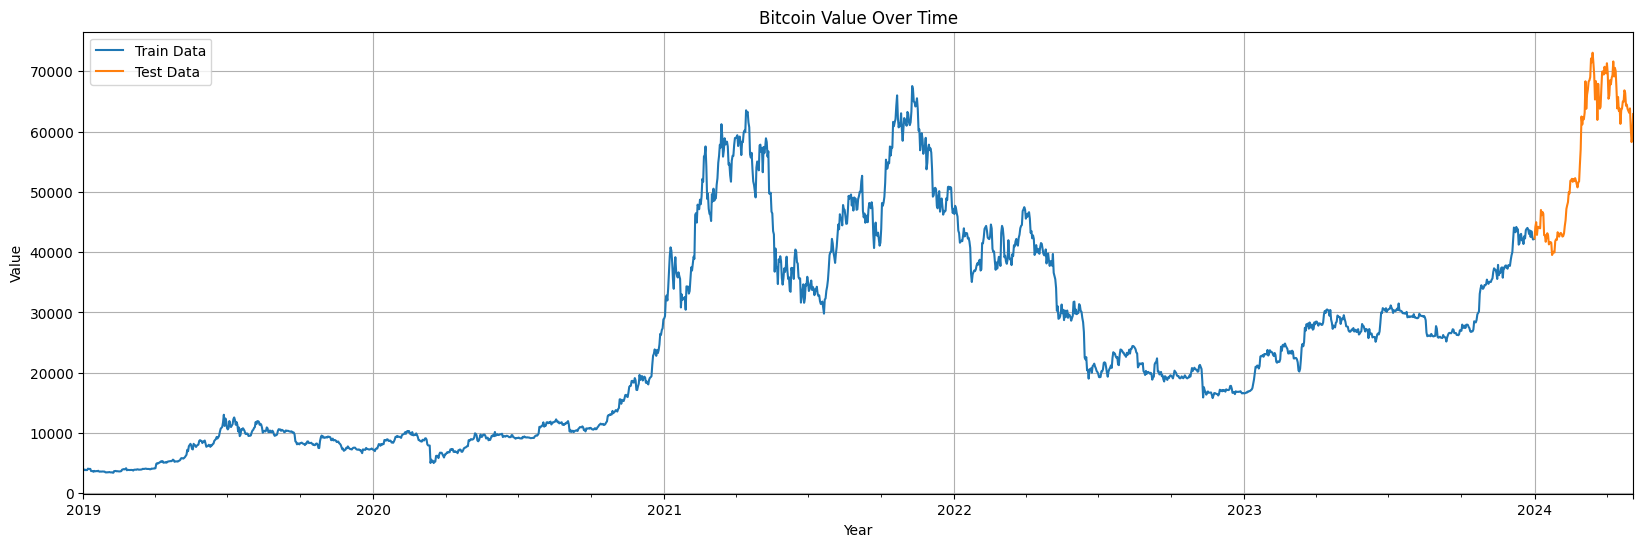

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
train_data['Open'].plot(label='Train Data')
test_data['Open'].plot(label='Test Data')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Bitcoin Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

# D

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the training data
scaler.fit(train_data[['Open']])

# Scale the training data
train_data_scaled = scaler.transform(train_data[['Open']])


# Scale the test data using the same scaler
test_data_scaled = scaler.transform(test_data[['Open']])


# E

In [5]:
import numpy as np

# Function to create input and output sequences for RNN
def create_sequences(data, timestep):
    x, y = [], []
    for i in range(timestep, len(data)):
        x.append(data[i - timestep:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

# Define the timestep
timestep = 60

# Create sequences for training data
x_train, y_train = create_sequences(train_data_scaled, timestep)

# Reshape input data for RNN
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Print shapes of x_train and y_train
print("x-train-shape=", x_train.shape)
print("y-train-shape=", y_train.shape)


x-train-shape= (1766, 60, 1)
y-train-shape= (1766,)


# F

In [6]:
import pandas as pd
import warnings
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten

In [7]:
# Initialize the Sequential model
model = Sequential()

# Define parameters
num_lstm_layers = 4
lstm_units = 50
dropout_rate = 0.2

# Add LSTM layers with dropout
for _ in range(num_lstm_layers - 1):
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))

# Add the last LSTM layer without return_sequences
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_rate))

# Add the output layer
model.add(Dense(units=1))


# G

In [8]:
# Compiling the model with mean squared error as the loss function and Adam optimizer
model.compile(loss="mean_squared_error",optimizer="adam")

# Train the model
model.fit(x_train, y_train, epochs= 100, batch_size=32)

Epoch 1/100
56/56 [==============================] - 10s 15ms/step - loss: 0.0194
Epoch 2/100
56/56 [==============================] - 1s 14ms/step - loss: 0.0052
Epoch 3/100
56/56 [==============================] - 1s 14ms/step - loss: 0.0049
Epoch 4/100
56/56 [==============================] - 1s 14ms/step - loss: 0.0044
Epoch 5/100
56/56 [==============================] - 1s 13ms/step - loss: 0.0038
Epoch 6/100
56/56 [==============================] - 1s 13ms/step - loss: 0.0037
Epoch 7/100
56/56 [==============================] - 1s 16ms/step - loss: 0.0035
Epoch 8/100
56/56 [==============================] - 1s 18ms/step - loss: 0.0035
Epoch 9/100
56/56 [==============================] - 1s 17ms/step - loss: 0.0033
Epoch 10/100
56/56 [==============================] - 1s 14ms/step - loss: 0.0031
Epoch 11/100
56/56 [==============================] - 1s 14ms/step - loss: 0.0028
Epoch 12/100
56/56 [==============================] - 1s 13ms/step - loss: 0.0028
Epoch 13/100
56/56 [====

# Prediction

In [10]:
# Extract the last 60 elements of train_data_scaled as a separate array
last_60_train_data = train_data_scaled[-60:]

# Concatenate the last 60 elements of train_data_scaled with test_data_scaled
combined_data = np.concatenate((last_60_train_data, test_data_scaled), axis=0)

# Initialize an empty list to store test input sequences
test_input_sequences = []

# Iterate over the concatenated test data to create input sequences
for i in range(timestep, combined_data.shape[0]):
    test_input_sequences.append(combined_data[i - timestep:i, 0])

# Convert the list of input sequences to a numpy array
x_test = np.array(test_input_sequences)

# Reshape the input sequences for compatibility with the RNN model
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Apply the model on the test data.

In [13]:
# Predict the output values using the trained model and the test input sequences
predicted_data = model.predict(x_test)

# Inverse transform the predicted data to obtain the original scale
predicted_data_inverse_transform = scaler.inverse_transform(predicted_data)

4/4 [==============================] - 2s 8ms/step


# H

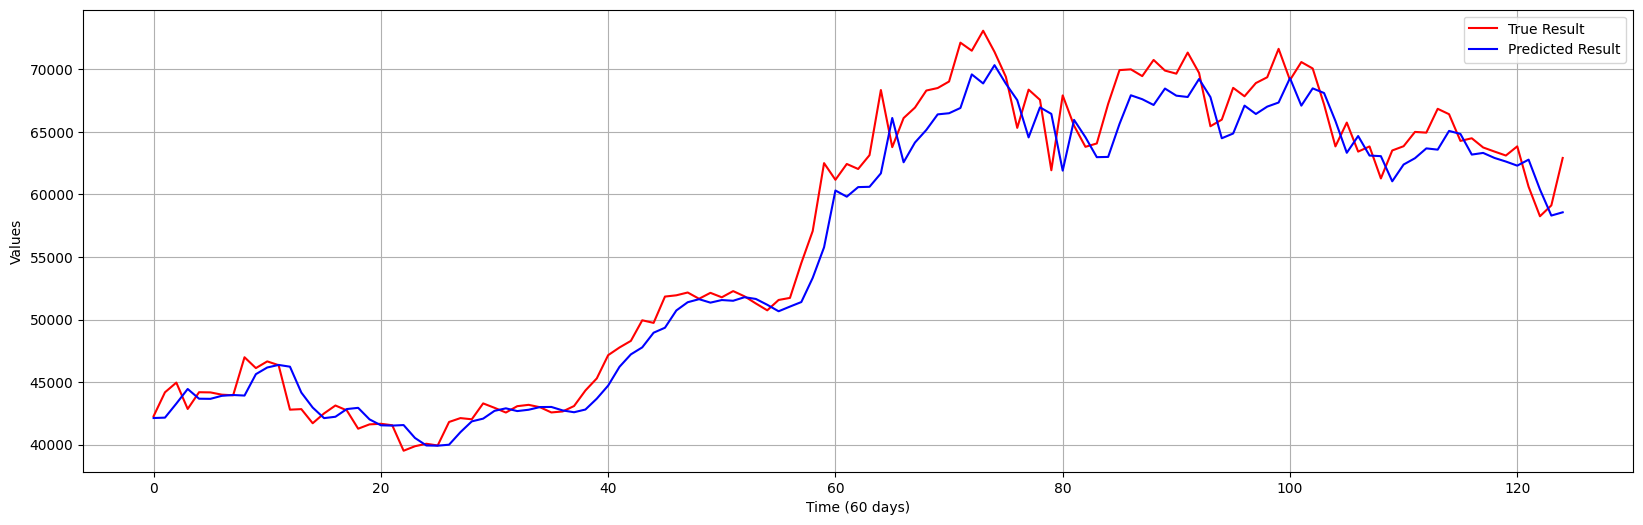

In [14]:
# Convert the 'Open' prices of the test data to a numpy array and reshape it
data_test = np.array(test_data[['Open']])
data_test = data_test.reshape(len(data_test), 1)

# Plotting the true test data and predicted data
plt.figure(figsize=(20, 6), facecolor='w', edgecolor='k')  # Setting figure size and background color
plt.plot(data_test, color="r", label="True Result")  # Plotting true test data in red
plt.plot(predicted_data_inverse_transform, color="b", label="Predicted Result")  # Plotting predicted data in blue
plt.legend()  # Adding legend to the plot
plt.xlabel("Time (60 days)")  # Adding label to the x-axis
plt.ylabel("Values")  # Adding label to the y-axis
plt.grid(True)  # Adding grid to the plot
plt.show()  # Displaying the plot

# I

**Advantages of Increasing Timestep:** <br>
Captures long-term dependencies and provides more contextual information. <br>
Helps in better generalization to unseen data. <br>

**Disadvantages of Increasing Timestep:** <br>
Increases computational complexity and risk of overfitting. <br>


**Advantages of Decreasing Timestep:** <br>
Faster training and reduced memory requirements.<br>

**Disadvantages of Decreasing Timestep:**<br>
Limited context and potential information loss, leading to poorer performance on tasks requiring long-term dependencies.<br>

**In essence,** choosing the timestep involves balancing the need for capturing long-term dependencies with computational efficiency and risk of overfitting.